In [56]:
import tensorflow as tf
import cv2 
import os
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection
import random

In [3]:
!unzip /content/train_set.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_set/images/1004.jpg  
  inflating: train_set/images/1005.jpg  
  inflating: train_set/images/1006.jpg  
  inflating: train_set/images/1007.jpg  
  inflating: train_set/images/1008.jpg  
  inflating: train_set/images/1009.jpg  
  inflating: train_set/images/1010.jpg  
  inflating: train_set/images/1011.jpg  
  inflating: train_set/images/1012.jpg  
  inflating: train_set/images/1013.jpg  
  inflating: train_set/images/1014.jpg  
  inflating: train_set/images/1015.jpg  
  inflating: train_set/images/1016.jpg  
  inflating: train_set/images/1017.jpg  
  inflating: train_set/images/1018.jpg  
  inflating: train_set/images/1019.jpg  
  inflating: train_set/images/1020.jpg  
  inflating: train_set/images/1021.jpg  
  inflating: train_set/images/1022.jpg  
  inflating: train_set/images/1023.jpg  
  inflating: train_set/images/1024.jpg  
  inflating: train_set/images/1025.jpg  
  inflating: train_set/images/1026.jpg  
  infl

In [42]:
# read labels
labels = pd.read_csv('/content/train_set/label.csv')
y= labels['label'].to_numpy()

In [26]:
# read points
n = 3000
for i in range(1,n+1):
  p_path = str(i).zfill(4)+'.mat'
  points_path = os.path.join('/content/train_set/points/', p_path)
  mat = scipy.io.loadmat(points_path)
  if 'faceCoordinatesUnwarped' in mat:
    cords = mat['faceCoordinatesUnwarped'] 
  else:
    cords = mat['faceCoordinates2']
  scaler = MinMaxScaler()
  scaler.fit(cords)
  cords = scaler.transform(cords)
  if i==1:
    cords_all = np.mat(cords.flatten())
  else:
    cords_all = np.append(cords_all, np.mat(cords.flatten()), axis = 0)

In [29]:
cords_all.shape

(3000, 156)

In [57]:
# data preprocessing

print('The number of class 0 is ' + str(n-sum(y)))
print('The number of class 1 is ' + str(sum(y)))
print('Only %.2f'% (sum(y)/n*100) + '% of total dataset are class 1. ')
print('So, it is an unbalanced dataset, we need to do some data preprocessing.')
print('Here, we are using oversampling to generate more class 1 datasets.')

mat_1 = np.add(np.where(y == 1),1)
n_oversample = (n-sum(y))-sum(y)

for i in range(n_oversample):
  samples_index = random.sample(list(list(mat_1)[0]), 2)

  p_path = str(samples_index[0]).zfill(4)+'.mat'
  points_path = os.path.join('/content/train_set/points/', p_path)
  mat = scipy.io.loadmat(points_path)
  if 'faceCoordinatesUnwarped' in mat:
    cords_0 = mat['faceCoordinatesUnwarped'] 
  else:
    cords_0 = mat['faceCoordinates2']

  p_path = str(samples_index[1]).zfill(4)+'.mat'
  points_path = os.path.join('/content/train_set/points/', p_path)
  mat = scipy.io.loadmat(points_path)
  if 'faceCoordinatesUnwarped' in mat:
    cords_1 = mat['faceCoordinatesUnwarped'] 
  else:
    cords_1 = mat['faceCoordinates2']
  
  cords_new = (cords_0 + cords_1) / 2
  scaler = MinMaxScaler()
  scaler.fit(cords_new)
  cords_new = scaler.transform(cords_new)
  cords_all = np.append(cords_all, np.mat(cords.flatten()), axis = 0)
  y = np.append(y,np.array(1))


The number of class 0 is 2402
The number of class 1 is 598
Only 19.93% of total dataset are class 1. 
So, it is an unbalanced dataset, we need to do some data preprocessing.
Here, we are using oversampling to generate more class 1 datasets.


In [58]:
cords_all.shape,y.shape

((4804, 156), (4804,))

In [59]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(cords_all, y,
                                                                            test_size=0.2,
                                                                            random_state=123)

In [ ]:
# # read points
# n=3000
# for i in range(1,n+1):
#   i_path = str(i).zfill(4)+'.jpg'
#   images_path = os.path.join('/content/train_set/images/', i_path)
#   img = cv2.imread(images_path,0)
#   if i == 1:
#     images = np.array(np.resize(img, (750,1000))/250.0).T
#   else:
#     img = np.array(np.resize(img, (750,1000))/250.0).T
#     images = np.dstack((images,img)) 

In [60]:
cords_tensor = tf.constant(cords_all).shape

In [61]:
# build the autoencoder
encoder = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),                                
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu')
      ])
decoder = tf.keras.models.Sequential([
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(156, activation='sigmoid')
      ])
autoencoder = tf.keras.models.Sequential([
      encoder,
      decoder
      ])

In [44]:
def rounded_accuracy(y_true, y_pred):
  return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [63]:
autoencoder.compile(optimizer=tf.keras.optimizers.SGD(1.5),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[rounded_accuracy])

In [68]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [64]:
history = autoencoder.fit(X_train, X_train, batch_size=32, epochs=100, 
                          validation_data = (X_test, X_test),
                          callbacks=[early_stopping_cb])

Epoch 1/100
121/121 [==============================] - 0s 3ms/step - loss: 0.5330 - rounded_accuracy: 0.9410 - val_loss: 0.5204 - val_rounded_accuracy: 0.9660
Epoch 2/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5197 - rounded_accuracy: 0.9665 - val_loss: 0.5206 - val_rounded_accuracy: 0.9562
Epoch 3/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5196 - rounded_accuracy: 0.9665 - val_loss: 0.5201 - val_rounded_accuracy: 0.9675
Epoch 4/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5195 - rounded_accuracy: 0.9664 - val_loss: 0.5200 - val_rounded_accuracy: 0.9649
Epoch 5/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5195 - rounded_accuracy: 0.9664 - val_loss: 0.5206 - val_rounded_accuracy: 0.9614
Epoch 6/100
121/121 [==============================] - 0s 2ms/step - loss: 0.5194 - rounded_accuracy: 0.9666 - val_loss: 0.5198 - val_rounded_accuracy: 0.9643
Epoch 7/100
121/121 [=========================

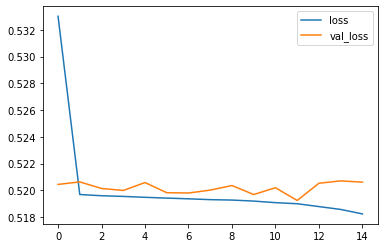

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
his_plot = pd.DataFrame(history.history)
plt.plot(his_plot['loss'],label = 'loss')
plt.plot(his_plot['val_loss'], label = 'val_loss')
plt.legend()


In [72]:
classification = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
])
encoder.trainable = False

In [73]:
y_train_class = tf.one_hot(y_train, depth=2)
y_test_class = tf.one_hot(y_test, depth=2)

classification.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=[tf.keras.metrics.AUC()])

history_class = classification.fit(X_train, y_train_class, batch_size=8, epochs=100, 
                          validation_data = (X_test, y_test_class),
                          callbacks=[early_stopping_cb])

Epoch 1/100
481/481 [==============================] - 1s 2ms/step - loss: 0.5449 - auc_4: 0.8378 - val_loss: 0.4550 - val_auc_4: 0.8730
Epoch 2/100
481/481 [==============================] - 1s 1ms/step - loss: 0.4225 - auc_4: 0.8922 - val_loss: 0.3635 - val_auc_4: 0.9290
Epoch 3/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3977 - auc_4: 0.9024 - val_loss: 0.3459 - val_auc_4: 0.9320
Epoch 4/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3921 - auc_4: 0.9054 - val_loss: 0.3432 - val_auc_4: 0.9277
Epoch 5/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3847 - auc_4: 0.9085 - val_loss: 0.3489 - val_auc_4: 0.9299
Epoch 6/100
481/481 [==============================] - 1s 2ms/step - loss: 0.3768 - auc_4: 0.9124 - val_loss: 0.3243 - val_auc_4: 0.9363
Epoch 7/100
481/481 [==============================] - 1s 1ms/step - loss: 0.3689 - auc_4: 0.9146 - val_loss: 0.3184 - val_auc_4: 0.9352
Epoch 8/100
481/481 [====================

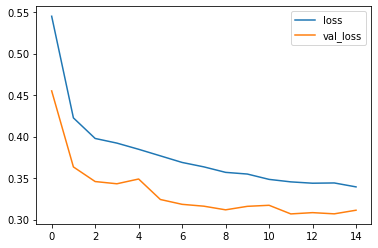

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
his_plot = pd.DataFrame(history_class.history)
plt.plot(his_plot['loss'],label = 'loss')
plt.plot(his_plot['val_loss'], label = 'val_loss')
plt.legend()

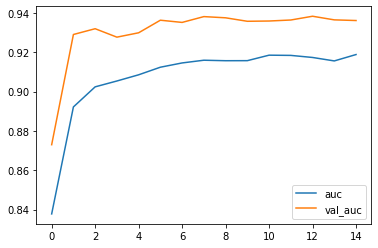

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
his_plot = pd.DataFrame(history_class.history)
plt.plot(his_plot['auc_4'],label = 'auc')
plt.plot(his_plot['val_auc_4'], label = 'val_auc')
plt.legend()